In [32]:
import mlflow
import dagshub
dagshub.init(repo_owner='rohanjoshi2005', repo_name='sentiment_analysis', mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/rohanjoshi2005/sentiment_analysis.mlflow")

Initialized MLflow to track repo "rohanjoshi2005/sentiment_analysis"

Repository rohanjoshi2005/sentiment_analysis initialized!

In [9]:
import pandas as pd
import numpy as np

In [10]:
df=pd.read_csv("Reddit_Data.csv")
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [11]:
df.dropna(inplace=True)

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df=df[~(df["clean_comment"].str.strip()== '')]

In [14]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [15]:
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
# preprocessing function

def cleaning(text):
    # converting to lowercase
    text=text.lower()
    
    # remove url's
    text = re.sub(r'http\S+|www\S+|https\S+','', text, flags=re.MULTILINE)

    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|\#', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    # tokens = text.split()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer=WordNetLemmatizer()
    tokens=[lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


In [17]:
# Apply cleaning to your dataset
df["clean_comment"]=df["clean_comment"].apply(cleaning)

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Vectorize the comments using bag of words
vectorizer=CountVectorizer(max_features=10000)

In [20]:
X=vectorizer.fit_transform(df["clean_comment"]).toarray()
y=df["category"]

In [21]:
X.shape

(36793, 10000)

In [23]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(36793, 10000))

In [24]:
y

0        1
1        1
2       -1
3        0
4        1
        ..
37244    0
37245    1
37246    0
37247    1
37248    0
Name: category, Length: 36793, dtype: int64

In [25]:
mlflow.set_experiment("Baseline")

2025/07/03 13:44:44 INFO mlflow.tracking.fluent: Experiment with name 'Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/2a1ece56c2054706aeea0e66913d7ff9', creation_time=1751530485901, experiment_id='0', last_update_time=1751530485901, lifecycle_stage='active', name='Baseline', tags={}>

In [26]:
# split the data into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

🏃 View run RandomForest_Baseline_TrainTestSplit at: https://dagshub.com/rohanjoshi2005/sentiment_analysis.mlflow/#/experiments/0/runs/32dda1c1dce34702b1dd7bdcdefeaa19
🧪 View experiment at: https://dagshub.com/rohanjoshi2005/sentiment_analysis.mlflow/#/experiments/0
Accuracy : 0.6462834624269602


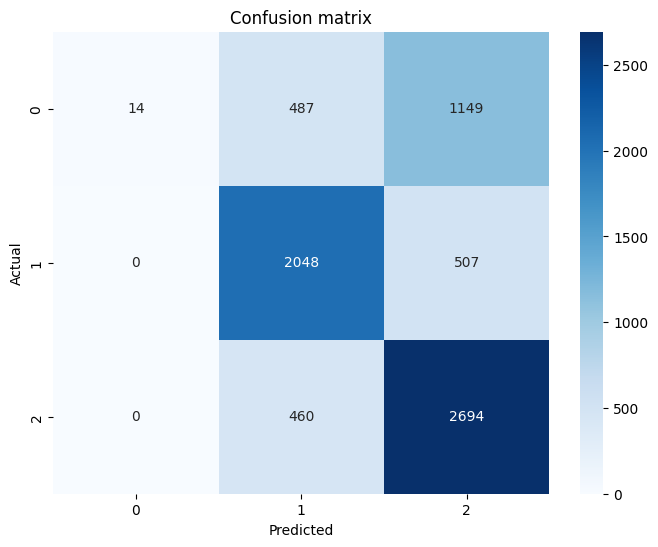

In [35]:
import mlflow.sklearn


with mlflow.start_run() as run:
  # Log a description for a run
  mlflow.set_tag("mlflow.runName","RandomForest_Baseline_TrainTestSplit")
  mlflow.set_tag("experiment_type","baseline")
  mlflow.set_tag("model_type","RandomForestClassifier")

  # Add a description
  mlflow.set_tag("description","Baseline RandomForest model for sentiment analysis using bag of words (BOW)")

  # log parameters for vectorizer
  mlflow.log_param("vectorizer_type","CountVectorizer")
  mlflow.log_param("Vectorizer_max_features",vectorizer.max_features)

  # Log Random Forest parameters
  n_estimators=200
  max_depth=15
  mlflow.log_param("n_estimators",n_estimators)
  mlflow.log_param("max_depth",max_depth)

  # Create and train
  model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,random_state=42)
  model.fit(X_train,y_train)

  # Make predictions on the test set
  y_pred=model.predict(X_test)

  # Log Metrics for each class and accuracy
  accuracy=accuracy_score(y_test,y_pred)
  mlflow.log_metric("accuracy",accuracy)

  classification_rep=classification_report(y_test,y_pred,output_dict=True)

  for label,metrics in classification_rep.items():
    if isinstance(metrics,dict):
      for metric,value in metrics.items():
        mlflow.log_metric(f"{label}_{metric}",value)

  # Confusion matrix plot
  conf_matrix=confusion_matrix(y_test,y_pred)
  plt.figure(figsize=(8,6))
  sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion matrix")


  # Save and log the confusion matrix plot
  plt.savefig("confusion_matrix.png")
  mlflow.log_artifact("confusion_matrix.png")

  # # Log the model
  # mlflow.sklearn.log_model(model,"model")

  # Log the random forest model
  mlflow.sklearn.save_model(model,"Random_Forest_Model")
  # Then log the directory as artifacts
  mlflow.log_artifacts("Random_Forest_Model")


  # optionally log the dataset
  df.to_csv("dataset.csv",index=False)
  mlflow.log_artifact("dataset.csv")

# display accuracy
print(f"Accuracy : {accuracy}")


In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02      1650
           0       0.68      0.80      0.74      2555
           1       0.62      0.85      0.72      3154

    accuracy                           0.65      7359
   macro avg       0.77      0.55      0.49      7359
weighted avg       0.73      0.65      0.57      7359



In [38]:
df.to_csv("reddit_preprocessing.csv",index=False)

In [40]:
pd.read_csv("reddit_preprocessing.csv").head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal wrappi...,0
4,benefit may want read living buddha living chr...,1
